In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/Spain/provincias_covid19_datos_sanidad_nueva_serie.csv')
df.columns

Index(['Fecha', 'cod_ine', 'provincia', 'Casos', 'Fallecidos',
       'Hospitalizados', 'UCI'],
      dtype='object')

In [3]:
import pandas as pd

# Load COVID data
df_covid = pd.read_csv('data/Spain/provincias_covid19_datos_sanidad_nueva_serie.csv')

# Load mobility data (already cleaned earlier)
df_mobility = pd.read_excel('data/Spain/Spanish-Mobility-Raw.xlsx', sheet_name='Data', skiprows=2)
mobility_dates = set(df_mobility.columns[0].split(':')[-1].strip()) if 'Fecha:' in df_mobility.columns[0] else set()

# From COVID dataset
covid_cities = set(df_covid['provincia'].unique())

# From mobility dataset — load and extract 'PROVINCIA ORIGEN' and 'PROVINCIA DESTINO'
df_mobility = pd.read_excel('data/Spain/Spanish-Mobility-Raw.xlsx', sheet_name='Data', skiprows=2)
mobility_cities = set(df_mobility['PROVINCIA ORIGEN'].dropna().unique()).union(
    set(df_mobility['PROVINCIA DESTINO'].dropna().unique())
)

rename_map = {
    'Illes Balears': 'Balears',
    'Valencia': 'Valencia/València',
}

invalid_entries = {'FR', 'PT', 'ex'}

# Drop foreign/invalid entries
mobility_cities_cleaned = mobility_cities - invalid_entries

# Rename mismatches
mobility_cities_final = set([rename_map.get(city, city) for city in mobility_cities_cleaned])

# Compare again
missing_after_cleaning = mobility_cities_final - covid_cities
print("Still missing after cleanup:", sorted(missing_after_cleaning))
mobility_cities_final

Still missing after cleanup: []


{'A Coruña',
 'Albacete',
 'Alicante/Alacant',
 'Almería',
 'Araba/Álava',
 'Asturias',
 'Badajoz',
 'Balears',
 'Barcelona',
 'Bizkaia',
 'Burgos',
 'Cantabria',
 'Castellón/Castelló',
 'Ceuta',
 'Ciudad Real',
 'Cuenca',
 'Cáceres',
 'Cádiz',
 'Córdoba',
 'Gipuzkoa',
 'Girona',
 'Granada',
 'Guadalajara',
 'Huelva',
 'Huesca',
 'Jaén',
 'La Rioja',
 'Las Palmas',
 'León',
 'Lleida',
 'Lugo',
 'Madrid',
 'Melilla',
 'Murcia',
 'Málaga',
 'Navarra',
 'Ourense',
 'Palencia',
 'Pontevedra',
 'Salamanca',
 'Santa Cruz de Tenerife',
 'Segovia',
 'Sevilla',
 'Soria',
 'Tarragona',
 'Teruel',
 'Toledo',
 'Valencia/València',
 'Valladolid',
 'Zamora',
 'Zaragoza',
 'Ávila'}

In [4]:
# Step 1: Sort and list all unique cleaned mobility cities
mobility_cities_final = sorted(mobility_cities_final)
print(f"✅ Total unique mobility cities: {len(mobility_cities_final)}")

# Step 2: Create a mapping from city name → unique ID
city_to_id = {city: idx for idx, city in enumerate(mobility_cities_final)}

# Optional: create reverse mapping too
id_to_city = {idx: city for city, idx in city_to_id.items()}

# Print first few mappings
print("\n🔢 Sample city to ID mapping:")
for city, cid in list(city_to_id.items())[:5]:
    print(f"{city} → {cid}")


✅ Total unique mobility cities: 52

🔢 Sample city to ID mapping:
A Coruña → 0
Albacete → 1
Alicante/Alacant → 2
Almería → 3
Araba/Álava → 4


In [5]:
import pandas as pd

# Convert to DataFrame
centrality_df = pd.DataFrame([
    {"Codmundv": cid, "nomemun": city}
    for city, cid in city_to_id.items()
])

# Save to CSV
centrality_df.to_csv("data/Spain/centrality_provinces.csv", index=False)

print("✅ Saved centrality file to: data/Spain/centrality_provinces.csv")


✅ Saved centrality file to: data/Spain/centrality_provinces.csv


Direct Forecasting RMSE: 2931.61
Direct Forecasting SMAPE: 38.44%
Direct Forecasting MDA: 61.94%


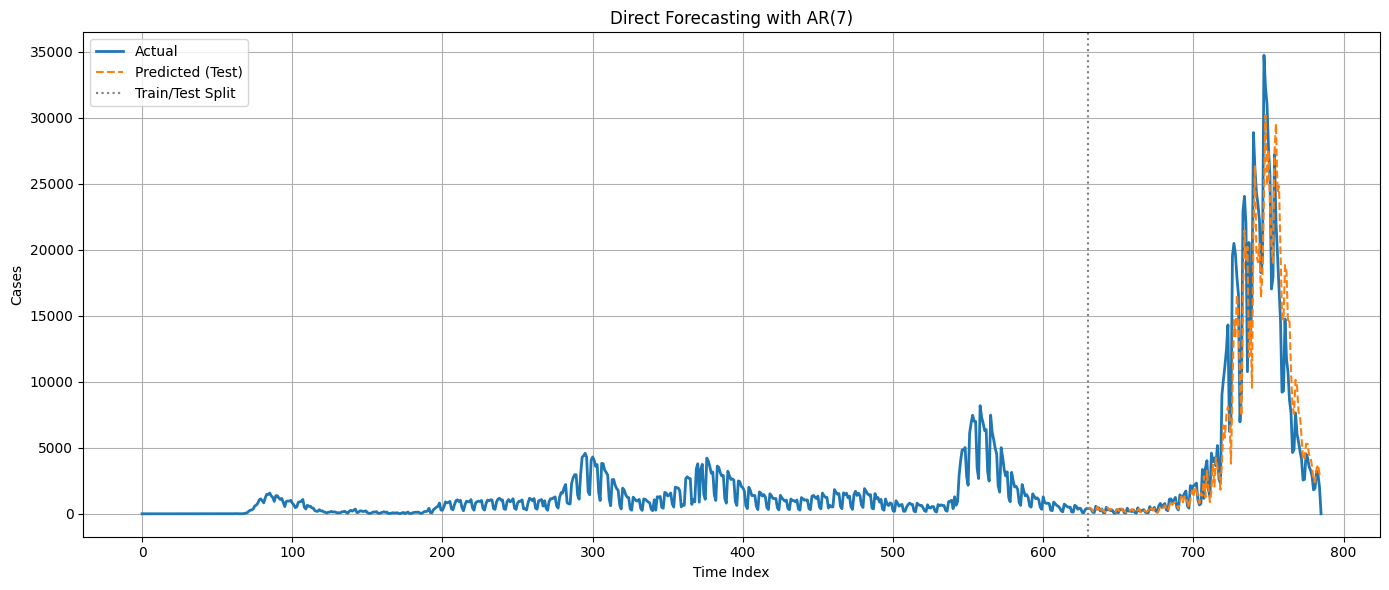

In [63]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('data/Spain/provincias_covid19_datos_sanidad_nueva_serie.csv')

# Convert 'Fecha' to datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Filter for Madrid
madrid_df = df[df['provincia'] == 'Barcelona'].sort_values('Fecha')

# Use normalized series if preferred, or raw:
cases = madrid_df['Casos'].reset_index(drop=True).values

# Create lag features for AR(7)
def create_lagged_features(series, lags=7):
    X, y = [], []
    for i in range(lags, len(series)):
        X.append(series[i-lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# SMAPE calculation
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / np.maximum(denominator, 1e-10)  # avoid div by 0
    return np.mean(diff) * 100

# MDA calculation
def mean_directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred)))

# Create features
X, y = create_lagged_features(cases, lags=7)

# 80/20 split
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Train direct forecasting model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict directly (1-step ahead each time using true lags)
pred = model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, pred))
mda = mean_directional_accuracy(y_test, pred)
smape_score = smape(y_test, pred)

print(f"Direct Forecasting RMSE: {rmse:.2f}")
print(f"Direct Forecasting SMAPE: {smape_score:.2f}%")
print(f"Direct Forecasting MDA: {mda:.2%}")

# Plot
plt.figure(figsize=(14, 6))
plt.plot(np.arange(len(cases)), cases, label='Actual', linewidth=2)
plt.plot(np.arange(split + 7, len(cases)), pred, label='Predicted (Test)', linestyle='--')
plt.axvline(x=split + 7, color='gray', linestyle=':', label='Train/Test Split')
plt.title("Direct Forecasting with AR(7)")
plt.xlabel("Time Index")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # slower, but reproducible
    torch.backends.cudnn.benchmark = False

set_seed(42)


/Users/youssefmalek/miniconda3/envs/ML/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 0, Loss: 0.3062
Epoch 10, Loss: 0.0168
Epoch 20, Loss: 0.0064
Epoch 30, Loss: 0.0121
Epoch 40, Loss: 0.0107
Epoch 50, Loss: 0.0067
Epoch 60, Loss: 0.0058
Epoch 70, Loss: 0.0048
Epoch 80, Loss: 0.0052
Epoch 90, Loss: 0.0053
Epoch 100, Loss: 0.0043
Epoch 110, Loss: 0.0044
Epoch 120, Loss: 0.0035
Epoch 130, Loss: 0.0037
Epoch 140, Loss: 0.0031
Epoch 150, Loss: 0.0027
Epoch 160, Loss: 0.0021
Epoch 170, Loss: 0.0017
Epoch 180, Loss: 0.0017
Epoch 190, Loss: 0.0014
Epoch 200, Loss: 0.0013
Epoch 210, Loss: 0.0013
Epoch 220, Loss: 0.0012
Epoch 230, Loss: 0.0011
Epoch 240, Loss: 0.0012
Epoch 250, Loss: 0.0011
Epoch 260, Loss: 0.0009
Epoch 270, Loss: 0.0010
Epoch 280, Loss: 0.0009
Epoch 290, Loss: 0.0010
Epoch 300, Loss: 0.0008
Epoch 310, Loss: 0.0009
Epoch 320, Loss: 0.0008
Epoch 330, Loss: 0.0007
Epoch 340, Loss: 0.0008
Epoch 350, Loss: 0.0007
Epoch 360, Loss: 0.0007
Epoch 370, Loss: 0.0006
Epoch 380, Loss: 0.0007
Epoch 390, Loss: 0.0006
✅ RMSE: 3443.36


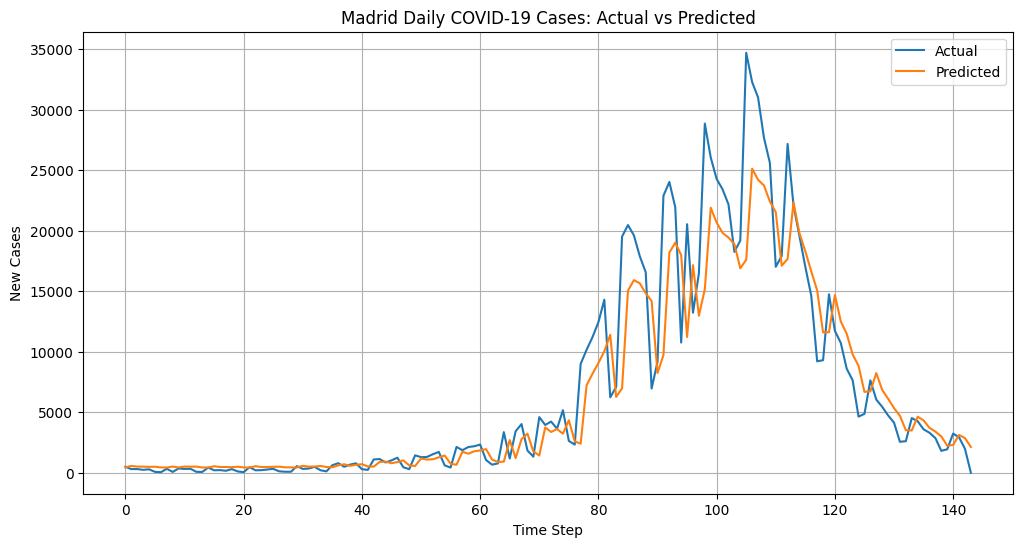

In [36]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Step 1: Get daily new cases
data = madrid_df['Casos'].values.reshape(-1, 1)

# Step 2: Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Step 3: Train-test split
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Step 4: Create sequences
def create_sequences(data, seq_length=14):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

seq_length = 14
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # [1, max_len, d_model]

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].to(x.device)
        return x


# Step 5: Define simple Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, model_dim=64, num_heads=16, num_layers=1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(model_dim, 1)

    def forward(self, x):
        # x: [batch, seq_len, 1]
        x = self.input_proj(x)  # [batch, seq_len, model_dim]
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)  # [seq_len, batch, model_dim]
        x = self.transformer(x)
        x = x[-1]  # take last time step's output
        return self.output_layer(x)

model = TransformerModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Step 6: Train
n_epochs = 400
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Step 7: Predict and inverse scale
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()
    predictions_rescaled = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.numpy())

# Step 8: Plot + RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f"✅ RMSE: {rmse:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual")
plt.plot(predictions_rescaled, label="Predicted")
plt.title("Madrid Daily COVID-19 Cases: Actual vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.show()
